In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Libraries

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

In [3]:
# Load the training dataset
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Load the test dataset
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# check the data types for each column
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
# check for nulls in the training dataset
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Handle missing rows in the training dataset

In [7]:
# Replace the missing rows in the Cabin column with 'Unknown' 
train_data['Cabin'] = train_data['Cabin'].fillna('Unknown')

# Replace the missing rows in the AGE column with the average age across all passengers
avg_age = round(train_data['Age'].mean(), 0)
train_data['Age'] = train_data['Age'].fillna(avg_age)

# Replace the missing rows in the Embark column with the most common PORT OF EMBARKATION
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])

In [8]:
# check AGAIN for nulls in the training dataset
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Handle missing rows in the test dataset

In [9]:
# check for nulls in the test dataset
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
# Replace the missing rows in the Cabin column with 'Unknown' 
test_data['Cabin'] = test_data['Cabin'].fillna('Unknown')

# Replace the missing rows in the AGE column with the average age across all passengers
avg_age = round(test_data['Age'].mean(), 0)
test_data['Age'] = test_data['Age'].fillna(avg_age)

# Replace the missing rows in the Fare column with the average fare
avg_fare = round(test_data['Fare'].mean(), 0)
test_data['Fare'] = test_data['Fare'].fillna(avg_fare)

In [11]:
# check again for nulls in the test dataset
test_data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Review the basic statistics about the train dataset

In [12]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.758889,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002570,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


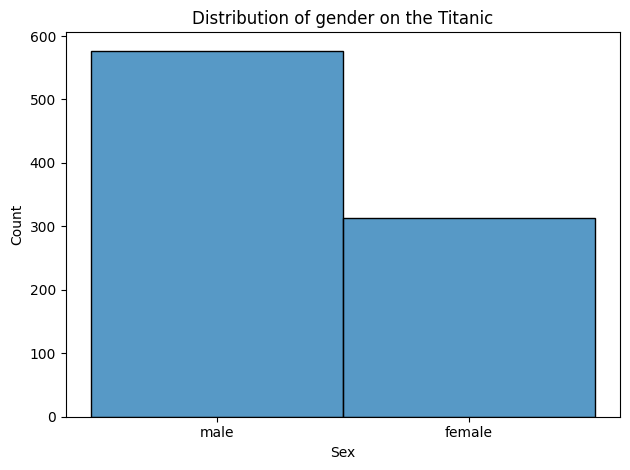

In [13]:
# Plot the distribution of gender on the titanic ship
sns.histplot(
    data=train_data,
    x='Sex'
)
plt.title('Distribution of gender on the Titanic')
plt.tight_layout()
plt.show()

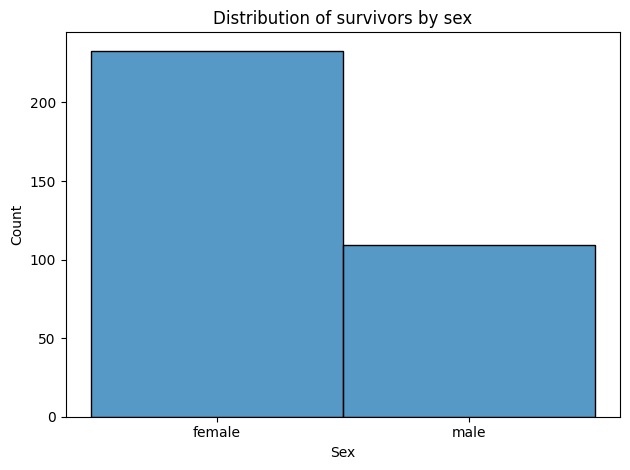

In [14]:
# Plot the distribution of survivors by sex
sns.histplot(
    data=train_data.loc[train_data['Survived']==1],
    x='Sex'
)
plt.title('Distribution of survivors by sex')
plt.tight_layout()
plt.show()

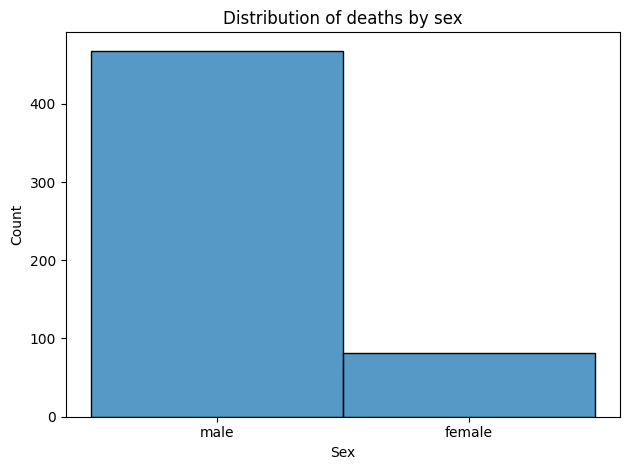

In [15]:
# Plot the distribution of deaths by sex
sns.histplot(
    data=train_data.loc[train_data['Survived']==0],
    x='Sex'
)
plt.title('Distribution of deaths by sex')
plt.tight_layout()
plt.show()

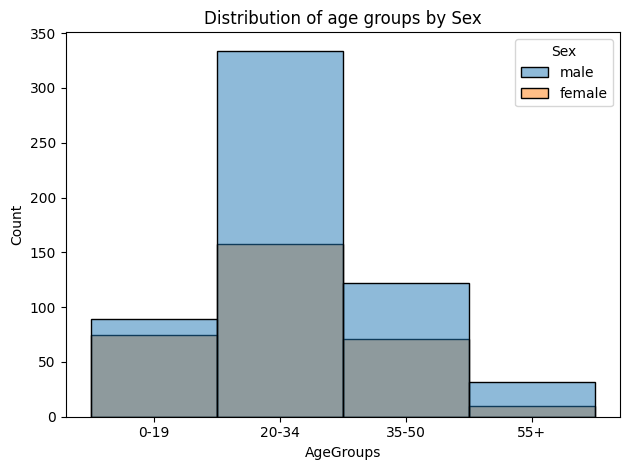

In [16]:
# Define the boundaries (bins) and labels for the age groups
bins = [0, 20, 35, 55, np.inf] # np.inf represents infinity for the upper limit
labels = ['0-19', '20-34', '35-50', '55+']

# Create a new column 'AgeGroup' with the categorized data
train_data_copy = train_data.copy()
train_data_copy['AgeGroups'] = pd.cut(train_data['Age'], bins=bins, labels=labels, right=False)

# Plot the distribution of Age groups by Sex
sns.histplot(
    data=train_data_copy,
    x='AgeGroups',
    hue='Sex'
)
plt.title('Distribution of age groups by Sex')
plt.tight_layout()
plt.show()

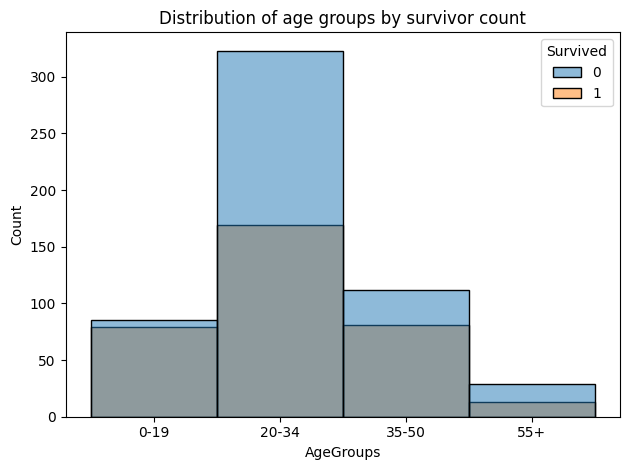

In [17]:
# Plot the distribution of Age groups by survivor
sns.histplot(
    data=train_data_copy,
    x='AgeGroups',
    hue='Survived'
)
plt.title('Distribution of age groups by survivor count')
plt.tight_layout()
plt.show()

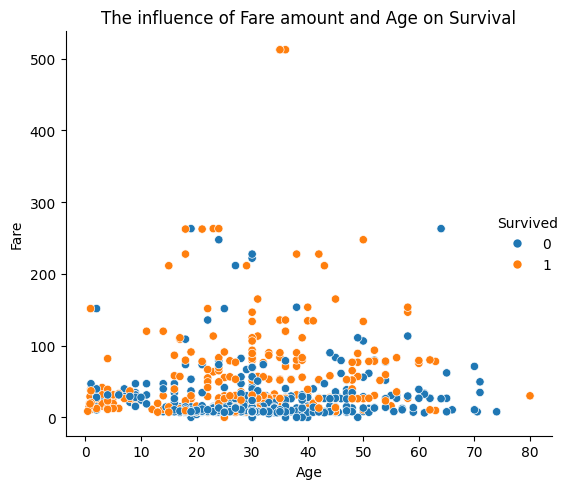

In [18]:
# Question: What is the reason behind some people surviving in the Titanic? Is it because of their pclass, their age?
sns.relplot(
    data=train_data,
    x='Age',
    y='Fare',
    hue='Survived'
)
plt.title('The influence of Fare amount and Age on Survival')
plt.tight_layout()
plt.show()

Based on the plot above, we can see that Age and the Fare amount played a significant role in determining whether a passenger would either survive or not.
It seems like most passengers who paid a <strong>lower</strong> Fare amount <i>(third class)</i> and were between ages <strong>20</strong> and <strong>40</strong> did not survive. In contrast, those who paid <strong>higher</strong> Fare amounts survived.

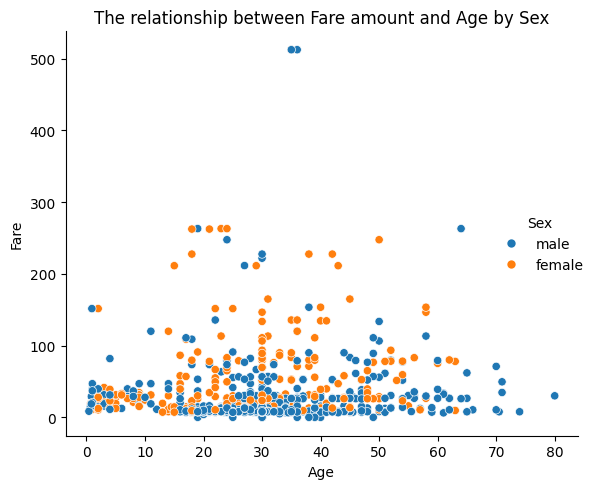

In [19]:
sns.relplot(
    data=train_data,
    x='Age',
    y='Fare',
    hue='Sex'
)
plt.title('The relationship between Fare amount and Age by Sex')
plt.tight_layout()
plt.show()

The plot above shows that most <strong>Males</strong> <i>(between ages 20 and 40)</i> and <strong>Females</strong> paid a lower Fare amount <i>(which probably means they were in the third class)</i>.

# Feature Engineering

In [20]:
# Remove unnecessary columns in both the training and test datasets.
columns_to_drop=['Name', 'Ticket', 'Cabin']

train_data.drop(
    columns=columns_to_drop,
    inplace=True
)

test_data.drop(
    columns=columns_to_drop,
    inplace=True
)

In [21]:
def encode_data(df):
    """
    This function is responsible for encoding the categorical data into numerical data.
    It makes use of the StandardScaler from sklearn to perform this task.

    Parameters:
        - df: This is the dataset which has numerical data.

    Returns:
        - pd.Concat: This is the resulting DataFrame that combines the encoded data and the original data 
    """
    try:
        # Convert the categorical data into numeric
        categorical_df = df.select_dtypes(include='object')
        
        # Initialize the OneHotEncoder object
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='error')
        
        encoded_features = encoder.fit_transform(categorical_df)
        feature_names = encoder.get_feature_names_out(categorical_df.columns)
        
        encoded_df = pd.DataFrame(
            encoded_features,
            columns=feature_names,
            index=df.index
        )
        
        return pd.concat(
            [
                df.drop(columns=categorical_df.columns, axis=1), 
                encoded_df
            ], 
            axis=1
        )
    except Exception as e:
        print('Error in encode_data: {}'.format(e))
    
encoded_train_data = encode_data(train_data)
encoded_train_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,4,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,5,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [22]:
def scale_data(df, target=None):
    """
    This function is responsible for scaling the numerical data in a dataset so that all numerical values are within the same scale range.

    Parameters:
        - df: This is the DataFrame which contains numerical data

    Returns:
        - pd.Concat: This is the result DataFrame that combines the scaled data and the original data.
    """
    try:
        if target is not None:
            X = df.drop('Survived', axis=1)
            
            # Initialize the StandardScaler object
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            feature_names = scaler.get_feature_names_out(X.columns)

        else:
            # Initialize the StandardScaler object
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(df)
            feature_names = scaler.get_feature_names_out(df.columns)
            
        
        X_scaled_df = pd.DataFrame(
            data=X_scaled,
            columns=feature_names,
            index=df.index
        )
        
        return pd.concat(
            [
                df.drop(columns=X_scaled_df.columns, axis=1),
                X_scaled_df
            ],
            axis=1
        )
    except Exception as e:
        print('Error in scale_data: {}'.format(e))

scaled_train_data = scale_data(encoded_train_data, target='yes')
scaled_train_data.head()

,Survived,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,-1.730108,0.827377,-0.597055,0.432793,-0.473674,-0.502445,-0.737695,0.737695,-0.482043,-0.307562,0.615838
1,1,-1.726220,-1.566107,0.634162,0.432793,-0.473674,0.786845,1.355574,-1.355574,2.074505,-0.307562,-1.623803
2,1,-1.722332,0.827377,-0.289251,-0.474545,-0.473674,-0.488854,1.355574,-1.355574,-0.482043,-0.307562,0.615838
3,1,-1.718444,-1.566107,0.403309,0.432793,-0.473674,0.420730,1.355574,-1.355574,-0.482043,-0.307562,0.615838
4,0,-1.714556,0.827377,0.403309,-0.474545,-0.473674,-0.486337,-0.737695,0.737695,-0.482043,-0.307562,0.615838


In [23]:
# Split the train dataset into training & testing datasets for model evaluation
X = scaled_train_data.drop(columns=['Survived'])
y = scaled_train_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Development

In [24]:
# Initialize the SVC
clf = SVC(kernel='linear', C=1, random_state=42)

# Fit and train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

In [25]:
# Evaluate the SVC classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       105
           1       0.75      0.70      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



In [26]:
# Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 100, 1000],
    'kernel':['rbf'],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}

# Initialize the GridSearchCV object
gs = GridSearchCV(
    estimator=SVC(), # classifier
    param_grid=param_grid,
    refit=True,
    verbose=3
)

# Fit and train the GridSearch
gs.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.622 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.622 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.627 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.627 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.620 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.811 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.818 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.789 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.761 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.803 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.797 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [27]:
# Get the best hyperparameters
print(f'Best params: {gs.best_params_}')
print(f'Best estimator(model): {gs.best_estimator_}')
print(f'Best score: {gs.best_score_}')

Best params: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best estimator(model): SVC(C=100, gamma=0.01)
Best score: 0.8229882793263075


In [28]:
# Evaluate the tuned model
gs_y_pred = gs.predict(X_test)

# Evaluate the GridSearch predictions
print(classification_report(y_test, gs_y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       105
           1       0.82      0.69      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



# Testing the model with Unseen data

In [29]:
# Encode the categorical data in the unseen data
encoded_test_data = encode_data(test_data)
encoded_test_data.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,0.0,1.0,0.0,1.0,0.0
1,893,3,47.0,1,0,7.0000,1.0,0.0,0.0,0.0,1.0
2,894,2,62.0,0,0,9.6875,0.0,1.0,0.0,1.0,0.0
3,895,3,27.0,0,0,8.6625,0.0,1.0,0.0,0.0,1.0
4,896,3,22.0,1,1,12.2875,1.0,0.0,0.0,0.0,1.0


In [30]:
# Apply scaling to the numerical data
scaled_test_data = scale_data(encoded_test_data)
scaled_test_data.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,-1.727912,0.873482,0.339424,-0.499470,-0.400248,-0.498423,-0.755929,0.755929,-0.568142,2.843757,-1.350676
1,-1.719625,0.873482,1.329924,0.616992,-0.400248,-0.513290,1.322876,-1.322876,-0.568142,-0.351647,0.740370
2,-1.711337,-0.315819,2.518523,-0.499470,-0.400248,-0.465104,-0.755929,0.755929,-0.568142,2.843757,-1.350676
3,-1.703050,0.873482,-0.254876,-0.499470,-0.400248,-0.483482,-0.755929,0.755929,-0.568142,-0.351647,0.740370
4,-1.694763,0.873482,-0.651076,0.616992,0.619896,-0.418487,1.322876,-1.322876,-0.568142,-0.351647,0.740370


In [31]:
# Make predictions with the classifier
new_y_pred = gs.predict(scaled_test_data)
new_y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [32]:
# Create a new dataframe
prediction_df = test_data[['PassengerId']]
prediction_df['Survived'] = new_y_pred 
prediction_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [33]:
prediction_df.to_csv('titanic_predictions.csv', index=False)
print('Saved!')

Saved!
